# Comparison of Similarity: Semsimian vs. Large Language Model Embeddings

## Case 1: HP vs HP

### Setup

In [46]:
!pip install oaklib==0.5.17 ontogpt==0.3.1 polars seaborn_polars matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [45]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn_polars as snl

In [17]:
simfile = 'hp_vs_hp_semsim.tsv'

### Semsim for HP through Semsimian and OAK

In [18]:
# This is just the descendants of "Abnormality of the voice" - it's only 24 objects
!runoak -vvv -i semsimian:sqlite:obo:hp similarity -p i .desc//p=i HP:0001608 @ .desc//p=i HP:0001608 -O csv -o {simfile}

# This line will do all PA vs all PA for HP. That's pretty large (>17k objects)
#!runoak -vvv -i semsimian:sqlite:obo:hp similarity -p i .desc//p=i HP:0000118 @ .desc//p=i HP:0000118

INFO:root:Setting other_languages=()
INFO:root:Settings = Settings(impl=None, autosave=False, associations_type=None, preferred_language=None, other_languages=())
INFO:root:Wrapping an existing OAK implementation to fetch sqlite:obo:hp
INFO:root:Locator: obo:hp
INFO:root:Ensuring gunzipped for https://s3.amazonaws.com/bbop-sqlite/hp.db.gz
INFO:root:Locator, post-processed: sqlite:////home/harry/.data/oaklib/hp.db
DEBUG:root:Paths to search: [PurePosixPath('model/schema'), PurePosixPath('schema'), PurePosixPath('linkml'), PurePosixPath('src/linkml'), PurePosixPath('src/model'), PurePosixPath('src/model/schema'), PurePosixPath('src/schema'), PurePosixPath('.')]
DEBUG:root:candidate model/schema not found
DEBUG:root:candidate schema not found
DEBUG:root:candidate linkml not found
DEBUG:root:candidate src/linkml not found
DEBUG:root:candidate src/model not found
DEBUG:root:candidate src/model/schema not found
DEBUG:root:candidate src/schema not found
INFO:root:out=hp_vs_hp_semsim.tsv <clas

In [19]:
!head {simfile}

subject_id	subject_label	subject_source	object_id	object_label	object_source	ancestor_id	ancestor_label	ancestor_source	object_information_content	subject_information_content	ancestor_information_content	jaccard_similarity	cosine_similarity	dice_similarity	phenodigm_score
HP:0001686	Loss of voice	None	HP:0031801	Vocal cord dysfunction	None	HP:0001608	Abnormality of the voice	None	None	None	10.278546254157375	0.6	None	None	2.4833702407201437
HP:0001686	Loss of voice	None	HP:0001604	Vocal cord paresis	None	HP:0001608	Abnormality of the voice	None	None	None	10.278546254157375	0.2727272727272727	None	None	1.6742878747388292
HP:0001686	Loss of voice	None	HP:0001609	Hoarse voice	None	HP:0001608	Abnormality of the voice	None	None	None	10.278546254157375	0.6	None	None	2.4833702407201437
HP:0001686	Loss of voice	None	HP:0005934	Imperfect vocal cord adduction	None	HP:0001608	Abnormality of the voice	None	None	None	10.278546254157375	0.5	None	None	2.2669964991324285
HP:0001686	Loss of voice	None	

In [22]:
simsdf = pl.read_csv(simfile, separator='\t')
simsdf

subject_id,subject_label,subject_source,object_id,object_label,object_source,ancestor_id,ancestor_label,ancestor_source,object_information_content,subject_information_content,ancestor_information_content,jaccard_similarity,cosine_similarity,dice_similarity,phenodigm_score
str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64
"""HP:0001686""","""Loss of voice""","""None""","""HP:0031801""","""Vocal cord dys…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.6,"""None""","""None""",2.48337
"""HP:0001686""","""Loss of voice""","""None""","""HP:0001604""","""Vocal cord par…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.272727,"""None""","""None""",1.674288
"""HP:0001686""","""Loss of voice""","""None""","""HP:0001609""","""Hoarse voice""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.6,"""None""","""None""",2.48337
"""HP:0001686""","""Loss of voice""","""None""","""HP:0005934""","""Imperfect voca…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996
"""HP:0001686""","""Loss of voice""","""None""","""HP:0008757""","""Unilateral voc…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.272727,"""None""","""None""",1.674288
"""HP:0001686""","""Loss of voice""","""None""","""HP:0001608""","""Abnormality of…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.75,"""None""","""None""",2.776492
"""HP:0001686""","""Loss of voice""","""None""","""HP:0001618""","""Dysphonia""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.6,"""None""","""None""",2.48337
"""HP:0001686""","""Loss of voice""","""None""","""HP:0001612""","""Weak cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996
"""HP:0001686""","""Loss of voice""","""None""","""HP:0001615""","""Hoarse cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996


In [28]:
simsdf["jaccard_similarity"].hist(bin_count=2)

break_point,category,jaccard_similarity_count
f64,cat,u32
-1.0,"""(-inf, -1.0]""",0
0.5,"""(-1.0, 0.5]""",414
inf,"""(0.5, inf]""",162


(0.0, 1.0, 0.0, 1.0)

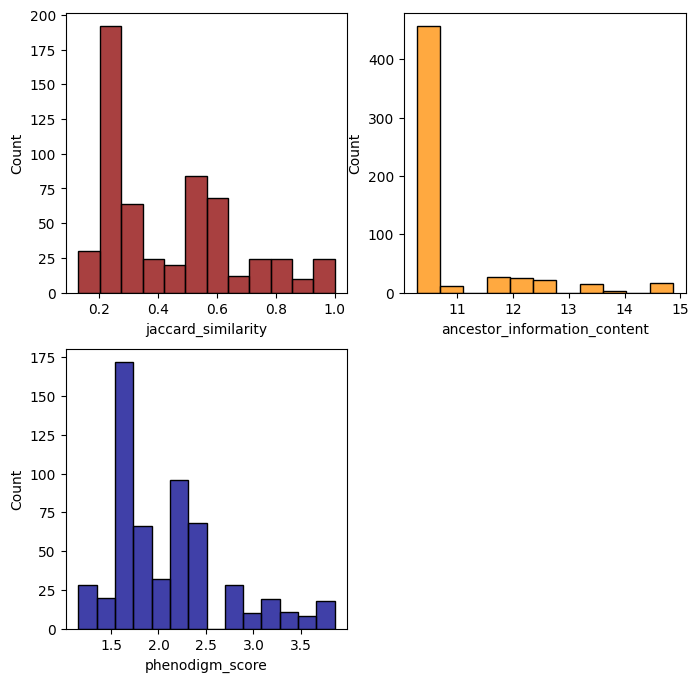

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
snl.histplot(simsdf, x='jaccard_similarity', color="darkred", ax=axs[0, 0])
snl.histplot(simsdf, x='ancestor_information_content', color="darkorange", ax=axs[0, 1])
snl.histplot(simsdf, x='phenodigm_score', color="darkblue", ax=axs[1, 0])
axs[1, 1].axis('off')

### Embeddings for HP through OntoGPT and GPT-3.5

The basic idea here is to get embeddings for all labels and get linear distance.